__Exercise 1:__ Linear SVM

*Data Processing (see code in homework4.py)*

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
import sklearn.metrics 

""" DATA PROCESSING """

# access data, concatenate to split later 
df_train = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train')
df_test = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test')
df = pd.concat([df_train, df_test])

# drop extra index 
df = df.drop('row.names', axis=1)

# select '1' as positives and '2', '3' as negatives, drop rest, apply +/- 1 labels
df = df[df.y.between(1, 3, inclusive=True)] 
df.y = df.y.apply(lambda x: 1 if x==1 else -1)

# splitting data (70/15/15 ratio)
n = len(df)

# note: data is ordered in increasing pattern by response
# (y=1, 2, ... 11, 1, 2, ... 11), hence split automatically provides 
# desired similarity in positive/negative-proportions for each set 
train, validate, test = np.split(df, [int(0.7*n), int(0.85*n)])

y_train = train.y.to_numpy()
y_val = validate.y.to_numpy()
y_test = test.y.to_numpy()

X_train = train.drop('y', axis=1).to_numpy()
X_val = validate.drop('y', axis=1).to_numpy()
X_test = test.drop('y', axis=1).to_numpy()

# standardize based off of training set 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

*Gradient Derivation*

Given our objective function, our gradient function is:

\begin{equation}
\nabla F(\beta)= 2\lambda\beta\:+\frac{\rho}{n}\sum_{i=1;\:y=+1}^{n}{\nabla \ell_{hh}(y_i,x_i^T\beta)}\:+\:\frac{1-\rho}{n}\sum_{i=1;\:y=-1}^{n}{\nabla \ell_{hh}(y_i,x_i^T\beta)}
\end{equation}

Where $\nabla \ell_{hh}(y_i,x_i^T\beta)$ is as follows. __*Note:*__ to differentiate with respect to $\beta$, it is necessary to represent the $t$ term in $\nabla \ell_{hh}(y, t)$ as $x_i^T\beta$.

\begin{equation}
\nabla \ell_{hh}(y_i, x_i^T\beta) := \left\{
                                        \begin{array}{ll}
                                            0 & \quad \text{if}\:\:y_i x_i^T\beta > 1+h \\
                                            \frac{1}{2h}(1+h-y_i x_i^T\beta)(-y_i x_i) & \quad \text{if}\:\:|1-y_i x_i^T\beta| \leq h \\
                                            -y_i x_i & \quad \text{if}\:\:y_i x_i^T\beta < 1-h
                                        \end{array}
                                     \right.
\end{equation}

*Function Definitions (see code in homework4.py)*

In [2]:
""" FUNCTIONS """

def huber_loss(y, t, h=0.5):
    lhh = None
    if y*t > 1+h:
        lhh = 0
    elif np.abs(1-(y*t)) <= h:
        lhh = ((1+h-(y*t))**2) / (4*h)
    elif y*t < 1-h:
        lhh = 1-(y*t)
    else: 
        print('Parameter failure in Huber loss function.')
    return lhh 

In [3]:
def grad_huber_loss(y, X, B, h=0.5):
    # expect col. vector X
    t = np.dot(X,B)
    grad_lhh = None
    if y*t > 1+h:
        grad_lhh = np.zeros(X.shape)
    elif np.abs(1-(y*t)) <= h:
        grad_lhh = (1/(2*h)) * (1+h-(y*t)) * (-y*X) 
    elif y*t < 1-h:
        grad_lhh = -y*X
    else: 
        print('Parameter failure in Huber loss function.')
    return grad_lhh 

In [4]:
def obj(B, rho, lmbda, X, y):
    penalty = lmbda * np.linalg.norm(B)**2
    pos_term = 0
    neg_term = 0 
    
    for i in np.where(y == 1)[0]:
        pos_term += huber_loss(y[i], np.dot(X[i], B))
    
    for i in np.where(y == -1)[0]:
        neg_term += huber_loss(y[i], np.dot(X[i], B)) 
    
    pos_term *= rho/len(y)
    neg_term *= (1-rho)/len(y)
    return penalty + pos_term + neg_term 

In [5]:
def grad(B, rho, lmbda, X, y):
    penalty = 2*lmbda*B
    pos_term = np.zeros(X.shape[1])
    neg_term = np.zeros(X.shape[1])
    
    for i in np.where(y == 1)[0]: 
        pos_term += grad_huber_loss(y[i], X[i], B)
    
    for i in np.where(y == -1)[0]:
        neg_term += grad_huber_loss(y[i], X[i], B)
    
    pos_term *= rho/len(y)
    neg_term *= (1-rho)/len(y)
    return penalty + pos_term + neg_term 

In [6]:
def backtracking(B, rho, lmbda, X, y, eta=1, alpha=0.5, gamma=0.8, max_iter=100):
    grad_B = grad(B, rho, lmbda, X, y)
    norm_grad_B = np.linalg.norm(grad_B)
    found_eta = 0
    num_iters = 0
    
    while found_eta == 0 and num_iters < max_iter:
        if obj(B-eta*grad_B, rho, lmbda, X, y) < obj(B, rho, lmbda, X, y)-alpha*eta*norm_grad_B**2:
            found_eta = 1
        elif num_iters == max_iter:
            raise('Max. iteration of BLS reached.')
        else:
            eta *= gamma
            num_iters += 1 
            
    return eta

In [7]:
def mylinearsvm(rho, lmbda, X, y, eps=5e-3):
    # init eta using L constant as described in class 
    w, v = np.linalg.eigh((1/len(y)) * np.dot(X.T, X))
    
    beta = np.zeros(X.shape[1])
    theta = np.zeros(X.shape[1])    
    eta = 1 / (max(w) + lmbda) 
    
    grad_theta = grad(theta, rho, lmbda, X, y)
    
    grad_beta = grad(beta, rho, lmbda, X, y)
    
    beta_vals = beta 
    t = 0 
    
    while np.linalg.norm(grad_beta) > eps:
        # hw3 soln used theta instead of beta as arg here -- unsure if error
        eta = backtracking(beta, rho, lmbda, X, y, eta=eta) 
        beta_new = theta - eta*grad_theta 
        theta = beta_new + (t/(t+3)) * (beta_new-beta)
        
        beta_vals = np.vstack((beta_vals, beta))
        grad_theta = grad(theta, rho, lmbda, X, y)
        grad_beta = grad(beta, rho, lmbda, X, y)
        beta = beta_new
        t += 1 
    
    return beta_vals 

*Training Performance ($\lambda=1, \rho=1$)*

In [8]:
""" TRAINING & TESTING """

# rho=1, lambda=1
final_beta = mylinearsvm(1, 1, X_train, y_train)[-1]

def performance_metrics(B, X, y, output=True):
    P = len(np.flatnonzero(y==1))
    N = len(np.flatnonzero(y==-1))
    TN = 0
    FN = 0
    TP = 0
    FP = 0
        
    for i in range(len(y)):
        if int(np.sign(np.dot(X[i], final_beta))) == 1:
            TP = TP+1 if y[i]==1 else TP
            FP = FP+1 if y[i]==-1 else FP
        else:
            TN = TN+1 if y[i]==-1 else TN
            FN = FN+1 if y[i]==1 else FN 
    
    misclassed = 100*(FP+FN)/len(y)
    sens = 100*TP/P
    spec = 100*TN/N
    
    if output:
        print('General misclassification error is: %.2f%%.' % misclassed)
        print('Achieved sensitivity is: %.2f%%.' % sens)
        print('Achieved specificity is: %.2f%%.' % spec)
            
    return (misclassed, sens, spec)


# feedback on rho=1, lambda=1
metrics = performance_metrics(final_beta, X_train, y_train)

General misclassification error is: 21.16%.
Achieved sensitivity is: 87.30%.
Achieved specificity is: 74.60%.


*Training Performance ($\lambda=1, \rho=0.1, 0.2, ..., 0.9, 1.0$)*

A recurring problem emerges (and is found in others' work, as well). The variation in $\rho$ seems to have a negligible effect on $\beta$, and hence a negligible effect on all performance metrics. Outside of derivation and coding issues, it is believed that qualities inherent to the data may be causing this behavior. Hence, the plotted lines are nearly flat (they increase slightly for the much larger values of $\rho$). 

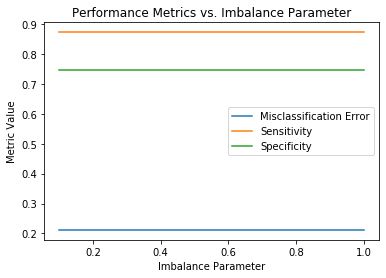

In [9]:
# lambda=1, rho=0.1 to 1.0
rhos = [x/10 for x in list(range(1,11))]
lmbda = 1 

misclass_errs = []
sensitivities = []
specificities = [] 

for rho in rhos:
    final_beta = mylinearsvm(rho, lmbda, X_train, y_train)[-1]
    metrics = performance_metrics(final_beta, X_train, y_train, output=False)
    misclass_errs.append(metrics[0]/100)
    sensitivities.append(metrics[1]/100)
    specificities.append(metrics[2]/100)

plt.plot(rhos, misclass_errs, label="Misclassification Error")
plt.plot(rhos, sensitivities, label="Sensitivity")
plt.plot(rhos, specificities, label="Specificity")
plt.title('Performance Metrics vs. Imbalance Parameter')
plt.xlabel('Imbalance Parameter')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

*Varying $\lambda$ & $\rho$*

We tune the algorithm along two dimensions: $\lambda=0.1, 0.2, ..., 0.9, 1.0$ and $\rho=0.1, 0.2, ..., 0.9, 1.0$. Our grid of values for $\lambda$ and $\rho$ is hence of size $10\:x\:10$. To calculate area-under-the-curve, where the ROC curve is defined as $\frac{sensitivity}{1-specificity}$, we use *__sklearn.metrics.roc_auc_score__*. The pair of $\lambda$ and $\rho$ values that optimize area-under-the-curve for the *__validation data__*, and the optimal AUC value itself, are as follow. Lastly computed is the sensitivity and specificity for this pair of values, on the *__testing set__*. 

In [10]:
# varying both lambda and rho
lambdas = rhos 

def predict(B, X=X_val, y=y_val):
    predictions=np.array([])
    
    for i in range(len(y)):
        predictions = np.append(predictions, int(np.sign(np.dot(X[i], B))))
        
    return predictions 


# makeshift grid search 
optimal_roc_auc = 0
optimal_rho = -1
optimal_lambda = -1 
optimal_B = -1

for l in lambdas:
    for r in rhos: 
        Bf = mylinearsvm(r, l, X_val, y_val)[-1]
        y_preds = predict(Bf)
        score = sklearn.metrics.roc_auc_score(y_val, y_preds)
        
        if score > optimal_roc_auc:
            optimal_roc_auc = score
            optimal_rho = r
            optimal_lambda = l
            optimal_B = Bf
            

print('For the validation set:\n\nThe optimal value of lambda is: %.1f.' % optimal_lambda)
print('The optimal value of rho is: %.1f.' % optimal_rho)
print('The corresponding, optimized area-under-the-ROC-curve is: %.2f.' % optimal_roc_auc)

metrics = performance_metrics(optimal_B, X_test, y_test, output=False)
print('\nFor the testing set (using above optimal parameters):\n')
print('The achieved sensitivity is: %.2f%%' % metrics[1])
print('The achieved specificity is: %.2f%%' % metrics[2])

For the validation set:

The optimal value of lambda is: 0.1.
The optimal value of rho is: 0.1.
The corresponding, optimized area-under-the-ROC-curve is: 0.98.

For the testing set (using above optimal parameters):

The achieved sensitivity is: 38.46%
The achieved specificity is: 85.71%


__Exercise 3__

*Linear Regression Insomnia*

For Bobbie, the time taken to train the model will play a significant part in the decision regarding which optimization algorithm he should use. That means if he is training a linear regression model (say, using gradient descent), I would recommend he use the *__Fast Gradient__* algorithm as discussed in class. This includes the use of *backtracking line search* for an adaptive step-size, and has the general advantage of converging to desirable solution faster than standard gradient descent algorithm. Note that if possible, I also recommend that Bobbie incorporate some form of *penalized/regularized* linear regression, since he is also tasked with validating the model on a dataset. This way, his model is discouraged from overfitting, without adding much time to the process. 

*The Next Big Thing*

I would not invest anything into Joey's company. The inclusion of the test set during training will naturally lead to a poorly-generalizable model. The model (never tested) will follow the noise of availabe samples too closely, or overfit. The combining of the data means that while Joey may predict his testing samples perfectly, the variance of his model will be high. That is, performance on other datasets will be undoubtedly inconsistent. I will urgently relay to Joey that, clearly, this means his model is not ready for real-world use. I will then re-evaluate why Joey has stayed my colleague for so long. 